In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from typing import List, Optional, Tuple, Union, Deque, Dict
from utils import Order, CancelOrder, AnonTrade, OwnTrade, OrderbookSnapshotUpdate, \
                  MdUpdate, update_best_positions, get_mid_price, PriorQueue

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(10, 'h').delta

/tmp/ipykernel_27543/4234343082.py:19: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  T = pd.Timedelta(10, 'h').delta


In [2]:
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [3]:
class Fodra_Labadie:
    def __init__(self, dt: float, gamma: float, trading_time: int, k: float, \
                 a: float, mu: float, sigma: float, eta: float, hold_time: float, ):
        """
            Args:
                delta_t(float): periodicity of trading
                hold_time: holding time in nanoseconds
                gamma(float): risk-measure
                a, mu, sigma (float): parametres of an Ornstein-Uhlenbeck process
                trading_time(int): the time during which we trade
                k(float): coeff, that we take from market data
                eta(float): inventory penalty
        """
        self.dt = dt
        self.gamma = gamma
        self.T = trading_time
        self.k = k
        self.a = a
        self.mu = mu
        self.sigma = sigma
        self.eta = eta
        self.hold_time = hold_time
        self.inventory = []

    def run(self, sim: Sim) -> \
            Tuple[List[OwnTrade], List[MdUpdate], List[Union[OwnTrade, MdUpdate]], List[Order]]:
        """
            This function runs simulation

            Args:
                sim(Sim): simulator
            Returns:
                trades_list(List[OwnTrade]): list of our executed trades
                md_list(List[MdUpdate]): list of market data received by strategy
                updates_list( List[ Union[OwnTrade, MdUpdate] ] ): list of all updates
                received by strategy(market data and information about executed trades)
                all_orders(List[Orted]): list of all placed orders
        """

        # market data list
        md_list: List[MdUpdate] = []
        # executed trades list
        trades_list: List[OwnTrade] = []
        # all updates list
        updates_list = []
        # current best positions
        best_bid = -np.inf
        best_ask = np.inf

        # last order timestamp
        prev_time = -np.inf
        # orders that have not been executed/canceled yet
        ongoing_orders: Dict[int, Order] = {}
        all_orders = []
        # position
        q = 0
        while True:
            # get update from simulator
            receive_ts, updates = sim.tick()
            if updates is None:
                break
            # save updates
            updates_list += updates
            for update in updates:
                # update best position
                if isinstance(update, MdUpdate):
                    best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                    md_list.append(update)
                elif isinstance(update, OwnTrade):
                    trades_list.append(update)
                    # calculating change in position
                    delta_pos = 0.001 if update.side == 'BID' else -0.001
                    q += delta_pos
                    # delete executed trades from the dict
                    if update.order_id in ongoing_orders.keys():
                        ongoing_orders.pop(update.order_id)
                else:
                    assert False, 'invalid type of update!'

            if receive_ts - prev_time >= self.dt:
                
                prev_time = receive_ts
                
                #calculating diff values from the paper
                mid_price = (best_bid + best_ask) / 2
                indif_price = mid_price * np.exp(-self.a * (self.T - receive_ts) / self.T) + self.mu * (1 - np.exp(-self.a * (self.T - receive_ts) / self.T)) \
                              - q * (2 * self.eta + self.gamma * (self.sigma ** 2) / (2 * self.a) * (1 - np.exp(-2 * self.a * (self.T - receive_ts) / self.T)))
    
                spread = (2 / self.gamma * np.log(1 + self.gamma / self.k) + 2 * self.eta + self.gamma * (self.sigma ** 2) / (2 * self.a) \
                         * (1 - np.exp(-2 * self.a * (self.T - receive_ts) / self.T)))
                p_ask = indif_price + spread / 2
                p_bid = indif_price - spread / 2

                # place order
                bid_order = sim.place_order(receive_ts, 0.001, 'BID', p_bid)
                ask_order = sim.place_order(receive_ts, 0.001, 'ASK', p_ask)
                ongoing_orders[bid_order.order_id] = bid_order
                ongoing_orders[ask_order.order_id] = ask_order

                all_orders += [bid_order, ask_order]

            to_cancel = []
            for ID, order in ongoing_orders.items():
                if order.place_ts < receive_ts - self.hold_time:
                    sim.cancel_order(receive_ts, ID)
                    to_cancel.append(ID)
            for ID in to_cancel:
                ongoing_orders.pop(ID)
            self.inventory.append(q)

        return trades_list, md_list, updates_list, all_orders, self.inventory

In [4]:
dt = pd.Timedelta(0.5, 's').delta
gamma = 0.1
trading_time = 1.6559874448376184e+18
k = 100
a = 1
mu = 1
sigma = 0.05
eta = 0.0001
hold_time = pd.Timedelta(10, 's').delta

/tmp/ipykernel_27543/3219932238.py:1: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  dt = pd.Timedelta(0.5, 's').delta
/tmp/ipykernel_27543/3219932238.py:9: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  hold_time = pd.Timedelta(10, 's').delta


In [5]:
strategy = Fodra_Labadie(dt, gamma, trading_time, k, hold_time, a, mu, sigma, eta)
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

/tmp/ipykernel_27543/756965089.py:2: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  latency = pd.Timedelta(10, 'ms').delta
/tmp/ipykernel_27543/756965089.py:3: FutureWarning: Timedelta.delta is deprecated and will be removed in a future version.
  md_latency = pd.Timedelta(10, 'ms').delta


In [6]:
sim = Sim(md, latency, md_latency)

In [7]:
%time trades_list, md_list, updates_list, all_orders, inventory = strategy.run(sim)

CPU times: user 37.9 s, sys: 39.2 ms, total: 38 s
Wall time: 38 s


In [8]:
%time df = get_pnl(updates_list)

CPU times: user 7.91 s, sys: 104 ms, total: 8.01 s
Wall time: 8 s


In [9]:
dt = pd.to_datetime(df.receive_ts)

In [10]:
df

,exchange_ts,receive_ts,total,BTC,USD,mid_price
0,1655942402249000000,1655942402250125991,0.000000,0.000,0.000000e+00,19977.45
1,1655942402249000000,1655942402259000000,0.000150,-0.001,1.997760e+01,19977.45
2,1655942402623000000,1655942402624789714,0.000150,-0.001,1.997760e+01,19977.45
3,1655942402655000000,1655942402657844605,0.000150,-0.001,1.997760e+01,19977.45
4,1655942403346000000,1655942403346968722,0.000150,-0.001,1.997760e+01,19977.45
...,...,...,...,...,...,...
3277066,1655978402600000000,1655978402608216711,-23909.813932,-69.926,1.426331e+06,20739.65
3277067,1655978402617000000,1655978402618951062,-23909.813932,-69.926,1.426331e+06,20739.65
3277068,1655978402617000000,1655978402618980391,-23909.813932,-69.926,1.426331e+06,20739.65
3277069,1655978402623000000,1655978402624258437,-23909.813932,-69.926,1.426331e+06,20739.65


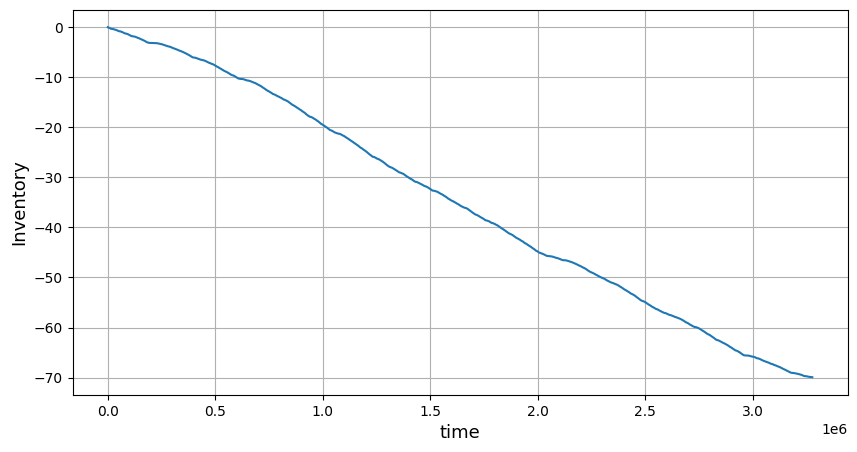

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(inventory)
plt.xlabel("time", fontsize=13)
plt.ylabel("Inventory", fontsize=13)
plt.grid()
plt.show()

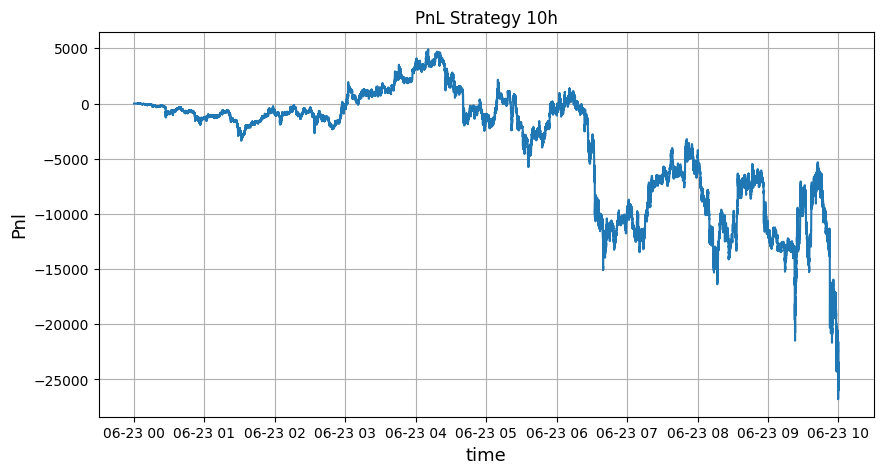

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel('time', fontsize=13)
plt.ylabel('Pnl', fontsize=13)
plt.title('PnL Strategy 10h')
plt.grid()
plt.show()